© 2019-2022, Anyscale. All Rights Reserved

![Anyscale Academy](../../images/AnyscaleAcademyLogo.png)

# Main Tutorial Notebook for RLlib ACM RecSys 2022

### Learning objectives
In this this tutorial, you will learn about:
 * [Defining a MDP for recommendation system using gym API](#recsys) -15 min
 * [Online RL - Bandits](#bandits) -15 min
 * [Online RL - DQN](#dqn) -15 min
 * [Break](#break) -5 min
 * [Offline RL](#offline-rl) -15 min

[Link to slides](https://github.com/anyscale/academy/blob/main/ray-rllib/acm_recsys_tutorial_2022/slides/rllib_acm_recsys_2022_slides.pdf)

<img src="./images/tutorial_overview.png" width="70%" />

In [1]:
# uncomment for running on anyscale
# import os; os.environ["PATH"] = "/home/ray/anaconda3/bin:" + os.environ["PATH"]
# !pip uninstall -y torch
# !python -m pip install torch==1.12.1
# !python -m pip install seaborn
# import torch
# print(f"torch: {torch.__version__}")

# !pip uninstall -y -r matplotlib
# !python3 -m pip install matplotlib==3.5.3
# import matplotlib
# print(f"matplotlib: {matplotlib.__version__}")

In [2]:
import time
import random
import numpy as np

import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint
from rllib_recsim.utils import pretty_print_configs

/opt/homebrew/Caskroom/miniforge/base/envs/ray/lib/python3.8/site-packages/tensorflow/core/framework/tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
/opt/homebrew/Caskroom/miniforge/base/envs/ray/lib/python3.8/site-packages/tensorflow/core/framework/tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
/opt/homebrew/Caskroom/miniforge/base/envs/ray/lib/python3.8/site-packages/tensorflow/core/framework/tensor_shape_pb2.py:29: DeprecationWarning: Call to deprecated create function Descriptor(). Note: Create unlinked descriptors is going to go away. Please

In [3]:
from ray import tune, rllib, data, air
from ray.tune import register_env

In [4]:
import recsim 
# import custom long-term satisfaction recommendation system gym env
from rllib_recsim.rllib_recsim import ModifiedLongTermSatisfactionRecSimEnv

## RecSim <a class="anchor" id="recsys"></a>

In this notebook, we will use <b><a href="https://github.com/google-research/recsim">Google's RecSim environment</a></b>, which was developed for the YouTube recommendation problem.  It is a configurable environment, where ideally you would plug in your own users, products, and embedding features.

**Some further readings**

- <a href="https://github.com/google-research/recsim">RecSim github</a>
- <a href="https://arxiv.org/pdf/1909.04847.pdf">RecSim paper</a>

The following image depicts all the components of the recsim packages:

<img src="./images/recsim_environment.png" width="70%" />

The environment is <i>Timelimit-based</i>, meaning the termination condition for an episode will be after a fixed number (10) of videos are watched. 

### Document Model

<img src="./images/document_model.png" width="70%" />

Documents represent the candidate pool of items that need to be recommended with features sampled in the range [0, 1].  In this tutorial, we use <b>1 single feature "sweetness"</b> drawn from a uniform distribution between [0.8, 1.0] to represent "chocolaty" items and [0, 0.2] for the "kaley" options. 
- The documents can be different at each step (produced by some "candidate generation" process), or fixed throughout the simulation.
- The recommendation algorithm observes the D candidate documents.  It then makes a selection (possibly ordered) of k documents and presents them in a "slate" to the user. We will focus on **slate size of 1** in this tutorial. 

In [5]:
env = ModifiedLongTermSatisfactionRecSimEnv()
print(env)

<ModifiedLongTermSatisfactionRecSimEnv<RecSimRewardScalingWrapper<MultiDiscreteToDiscreteActionWrapper<RecSimObservationSpaceWrapper<RecSimResetWrapper<RecSimGymEnv instance>>>>>>


The printed environment shows the main RecSim environment which follows [gym API](https://www.gymlibrary.dev/api/core/). For more info on how the environment is actually implemented we refer you to the source code acompanied with this tutorial [link](https://github.com/anyscale/academy/blob/main/ray-rllib/acm_recsys_tutorial_2022/rllib_recsim/rllib_recsim.py).

Let's use `env.reset()` to begin the interaction with the environment:

```
gym.Env.reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None) → Tuple[ObsType, dict]
Resets the environment to an initial state and returns the initial observation.
```

In [6]:
obs = env.reset()
pprint(obs)

OrderedDict([('user', array([], dtype=float32)),
             ('doc',
              {'0': array([0.99572366], dtype=float32),
               '1': array([0.15983172], dtype=float32),
               '10': array([0.8529111], dtype=float32),
               '11': array([0.15484674], dtype=float32),
               '12': array([0.89123005], dtype=float32),
               '13': array([0.11368679], dtype=float32),
               '14': array([0.80375797], dtype=float32),
               '15': array([0.1235271], dtype=float32),
               '16': array([0.92241913], dtype=float32),
               '17': array([0.1233868], dtype=float32),
               '18': array([0.9887496], dtype=float32),
               '19': array([0.13636406], dtype=float32),
               '2': array([0.8922959], dtype=float32),
               '3': array([0.15610583], dtype=float32),
               '4': array([0.8236549], dtype=float32),
               '5': array([0.12798421], dtype=float32),
               '6': array([0.8

### User Model

<img src="./images/user_model.png" width="70%" />

In RecSim users are representation by a set of features some of which could be latent hidden variables not observed by our recommendation system during live interaction. In this tutorial we assume that a sampled user from the world does not own any observable features like age, gender, etc. and our AI should infer the latent state of the user from its history of interactions in the current session. 
- The user examines a "slate" of recommended items and makes a choice of one item. After making their choice, the user emits an engagement score which indicates how much that user was engaged with that particular item they chose. The agent has to learn to estimate the latent states of the user that shape their choice model in the future. 

In [7]:
# observable user features
obs['user']

array([], dtype=float32)

In [8]:
# latent user features (HACK: we can cheat and access the user state within the env)
pprint(env.get_user_state())

{'choc_mean': 5.0,
 'choc_stddev': 0.0,
 'innovation_stddev': 1e-05,
 'kale_mean': 0.0,
 'kale_stddev': 0.0,
 'memory_discount': 0.7,
 'net_positive_exposure': 1.0,
 'satisfaction': 0.7109495026250039,
 'sensitivity': 0.9,
 'time_budget': 10}


### User Choice

<img src="./images/user_choice_model.png" width="70%" />

This module controls how a particular user would **respond** to a set of recommendations and how its **latent state would evolve** as a function of this interaction. 
In the environment in this tutorial, engagement is assumed to be a function of two competing phenomenas:
-   The love of the user for sweet items ($sweetness(item_t)$)
-   The long term satisfaction which cares about healthier options. It is inversely correlated with the sweetness of items suggested so far ($satisfaction_{t-1}$)

$$satisfaction_t := satisfaction_{t-1} * \sigma(-sweetness(item_{t}))$$
$$r(item_t) \propto sweetness(item_t) * satisfaction_{t-1}$$

i.e. If a user who loves chocolates have not had chocolate for a while, a chocolate item would be more engaging than a kaley item. On the other hand if we keep recommending chocolate to the same person, they may lose interest and not use our recommendations. 

In [9]:
obs = env.reset()
pprint(obs)

OrderedDict([('user', array([], dtype=float32)),
             ('doc',
              {'0': array([0.8719016], dtype=float32),
               '1': array([0.08740639], dtype=float32),
               '10': array([0.9140394], dtype=float32),
               '11': array([0.0877203], dtype=float32),
               '12': array([0.99767476], dtype=float32),
               '13': array([0.02040896], dtype=float32),
               '14': array([0.84177536], dtype=float32),
               '15': array([0.0322619], dtype=float32),
               '16': array([0.9306217], dtype=float32),
               '17': array([0.05065832], dtype=float32),
               '18': array([0.89326215], dtype=float32),
               '19': array([0.04888512], dtype=float32),
               '2': array([0.93952626], dtype=float32),
               '3': array([0.01204509], dtype=float32),
               '4': array([0.93335336], dtype=float32),
               '5': array([0.13412757], dtype=float32),
               '6': array([0.

The observation space is a dictionary of four keys. 
- The `user` key is empty, because there is no observable user features. 
- The `doc` key contains a set of documents presented with numerical keys. Each doc item has a scalar score representing its sweetness. 
- The `response` key includes a single record of `click` and `engagement` from the immediate previous interaction. 
- The `time` shows a normalized timestep within the session for this user. -0.5 corresponds to the beginnig of the interaction and +0.5 corresponds to the end of the interaction.

Let's now checkout environment's reward behavior. Let's see what happens if we always pick the sweetest item and plot the reward over time.

In [10]:
# Let's checkout the reward space
# TODO: code here
rewards = []
obs = env.reset()
done = False
while not done:
    action = int(max(obs['doc'], key=lambda x: obs['doc'][x]))
    next_obs, reward, done, info = env.step(action)
    obs = next_obs
    rewards.append(reward)

Text(0.5, 0, 'step')

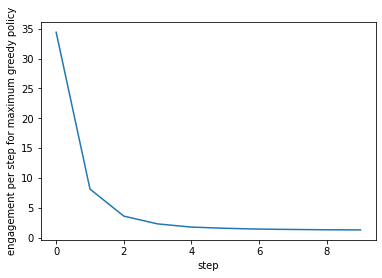

In [11]:
plt.plot(rewards)
plt.ylabel('engagement per step for maximum greedy policy')
plt.xlabel('step')

We can note a couple of things here already:

1. The immediate engagement would be high initially when the sweetest item is suggested for the first time.
2. As we keep recommending the sweetest items, the user satisfaction significantly tampers off and as a result engagement quickly drops.
3. Episodes seem to last for 10 timesteps.

#### Exercise (2 min):
Instead of picking the item with the highest feature, pick the item with the lowest feature and see what happens?

- What do your observations imply about this environment?
- What policy maximizes engagement with the user?

In [12]:
obs = env.reset()
rewards = []
done = False
while not done:
    # TODO (exercise): code here
    action = int(min(obs['doc'], key=lambda x: obs['doc'][x]))
    obs, reward, done, info = env.step(action)
    rewards.append(reward)

Text(0.5, 0, 'step')

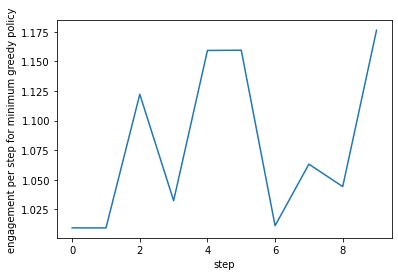

In [13]:
plt.plot(rewards)
plt.ylabel('engagement per step for minimum greedy policy')
plt.xlabel('step')

## Getting some baselines on trying to maximize engagement
Next we will run some simple baselines to get a feeling of the reward we can accumulate in these environments using simple policies.

- Greedy minimum feature value (recommending the kaliest option)
- Greedy maximum feature value (recommending the chocoletiest option)
- random policy (recommending random items from the pool)


In [14]:
# Function that measures and outputs the random baseline reward.
# This computes  the expected accumulated reward per episode, if we act randomly (recommend random items) at each time step.
def calc_baseline(baseline_type="random",
                  episodes=100):

    env = ModifiedLongTermSatisfactionRecSimEnv()
    # Reset the env.
    obs = env.reset()

    # Number of episodes already done.
    num_episodes = 0
    # Current episode's accumulated reward.
    episode_reward = 0.0
    epsiode_satisfaction = []
    # Collect all episode rewards here to be able to calculate a random baseline reward.
    episode_rewards = []
    episode_satisfactions = []
    
    # Enter while loop (to step through the episode).
    time_step = 0
    while num_episodes < episodes:
        # Produce an action
        random_action = random.randint(0, 20)# TODO: code here
        argmax_action = int(max(obs['doc'], key=lambda x: obs['doc'][x]))
        argmin_action = int(min(obs['doc'], key=lambda x: obs['doc'][x]))

        action_dict = {
            'argmax': argmax_action, # greedy choc
            'argmin': argmin_action, # greedy kale
            'random': random_action,
        }

        action = action_dict[baseline_type]
        
        # Send the action to the env's `step()` method to receive: obs, reward, done, and info.
        obs, reward, done, _ = env.step(action)
        
        # Accumulate the rewards
        episode_reward += reward
        
        # Append satisfaction to episode_satiscation
        epsiode_satisfaction.append(
            env.environment._user_model._user_state.satisfaction
        )

        time_step += 1
        # Check, whether the episde is done, if yes, reset and increase episode counter.
        if done:
            if num_episodes % 99 == 0:
                print(f" {num_episodes} ", end="")
            elif num_episodes % 9 == 0:
                print(".", end="")
                
            # increment on end of episode
            num_episodes += 1
            time_step = 0
            obs = env.reset()
            episode_rewards.append(episode_reward)
            episode_reward = 0.0
            episode_satisfactions.append(np.mean(epsiode_satisfaction))

    # Print out and return mean episode reward (and standard error of the mean).
    env_mean_reward = np.mean(episode_rewards)
    env_sd_reward = np.std(episode_rewards)

    # Print out the satisfaction over the episodes
    env_mean_satisfaction = np.mean(episode_satisfactions)
    env_sd_satisfaction = np.std(episode_satisfactions)
    
    print(f"\nMean {baseline_type} baseline reward: {env_mean_reward:.2f}+/-{env_sd_reward:.2f}, satisfaction: {env_mean_satisfaction:.2f}+/-{env_sd_satisfaction:.2f}")

    return env_mean_reward, episode_rewards

In [15]:
num_episodes = 1000
kaliest_baseline, _ = calc_baseline(baseline_type="argmin", episodes=num_episodes)
sweetest_baseline,  _ = calc_baseline(baseline_type="argmax", episodes=num_episodes)
random_baseline, _ = calc_baseline(baseline_type="random", episodes=num_episodes)

 0 .......... 99 .......... 198 .......... 297 .......... 396 .......... 495 .......... 594 .......... 693 .......... 792 .......... 891 .......... 990 .
Mean argmin baseline reward: 10.88+/-0.27, satisfaction: 0.91+/-0.00
 0 .......... 99 .......... 198 .......... 297 .......... 396 .......... 495 .......... 594 .......... 693 .......... 792 .......... 891 .......... 990 .
Mean argmax baseline reward: 56.51+/-1.43, satisfaction: 0.14+/-0.00
 0 .......... 99 .......... 198 .......... 297 .......... 396 .......... 495 .......... 594 .......... 693 .......... 792 .......... 891 .......... 990 .
Mean random baseline reward: 96.45+/-23.88, satisfaction: 0.51+/-0.01


### Discussion about the baselines

For every baseline we have printed out not only the engagement score of the entire user session but also the average of the satisfaction term over the entire session as well.

The question is whether we automatically learn an optimal policy in this recommendation enviornement that is better than random?


## Questions (2 min)

- Any questions so far?

# Bandit <a class="anchor" id="bandits"></a>

Bandit is a classical algorithm used in RecSys that is known to optimize single-step objectives. **They maximize immediate engagement not accumulated engagement over the user session.**

Any RL algorithm can be turned into a contextual bandit algorithm if the discount factor of the Markov Decision Process is set to 0.0. This will result in maximizing the immediate reward and hence a bandit solution. 

<img src="./images/gamma_0_vs_1.png" width="70%" />

In this section, we will use Deep Q-Networks([DQN](https://docs.ray.io/en/latest/rllib/rllib-algorithms.html#dqn)) implementation in [RLlib](https://docs.ray.io/en/latest/rllib/index.html) to train an agent both with $\gamma = 0$ and $\gamma = 0.99$ to see the difference between a bandit solution and an RL solution.


In [16]:
register_env("modified-lts", lambda config: ModifiedLongTermSatisfactionRecSimEnv())

In [17]:
from ray.rllib.algorithms.dqn import DQNConfig, DQN

In [18]:
# set up the environment config
bandit_config = DQNConfig()
# setup the env
bandit_config = bandit_config.environment(env="modified-lts")
# setup framework to be torch
bandit_config = bandit_config.framework("torch")
# setup the gamma
bandit_config = bandit_config.training(gamma=0.0)

In [19]:
pretty_print_configs(bandit_config)

{'env': 'modified-lts', 'framework': 'torch', 'gamma': 0.0}

In RLlib we can run training loops Using `tune.Tuner()` with stopping condition (recommended)


In [20]:
"""
Use tune.Tuner(
    algo
    param_space=..., 
    run_config=air.RunConfig(
        local_dir='./rllib_notebook/offline_rl/bandits',
        stop={'training_iteration': 1}
    ))
    tuner.fit()
"""
# TODO: Code here
tuner = tune.Tuner(
    DQN,
    param_space=bandit_config.to_dict(),
    run_config=air.RunConfig(
        local_dir='./rllib_notebook/offline_rl/bandits',
        stop={'training_iteration': 1}
    )
)

result_bandit = tuner.fit()

2022-09-16 10:39:43,537	INFO worker.py:1517 -- Started a local Ray instance.


(pid=65036) /opt/homebrew/Caskroom/miniforge/base/envs/ray/lib/python3.8/site-packages/tensorflow/core/framework/tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
(pid=65036)   DESCRIPTOR = _descriptor.FileDescriptor(
(pid=65036) /opt/homebrew/Caskroom/miniforge/base/envs/ray/lib/python3.8/site-packages/tensorflow/core/framework/tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
(pid=65036)   _descriptor.FieldDescriptor(
(pid=65036) /opt/homebrew/Caskroom/miniforge/base/envs/ray/lib/python3.8/site-packages/tensorflow/core/framework/tensor_shape_pb2.py:29: DeprecationWarning: Call to deprecated create function Descriptor(). N

Trial name,agent_timesteps_total,counters,custom_metrics,date,done,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,episodes_total,experiment_id,hostname,info,iterations_since_restore,node_ip,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_trained,num_env_steps_trained_this_iter,num_faulty_episodes,num_healthy_workers,num_recreated_workers,num_steps_trained_this_iter,perf,pid,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,sampler_results,time_since_restore,time_this_iter_s,time_total_s,timers,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
DQN_modified-lts_8d513_00000,1000,"{'num_env_steps_sampled': 1000, 'num_env_steps_trained': 0, 'num_agent_steps_sampled': 1000, 'num_agent_steps_trained': 0}",{},2022-09-16_10-39-50,True,10,{},157.279,98.668,50.9246,100,100,846b258bc9044ae8852638ed1747052a,Kouroshs-MacBook-Pro-13,"{'learner': {}, 'num_env_steps_sampled': 1000, 'num_env_steps_trained': 0, 'num_agent_steps_sampled': 1000, 'num_agent_steps_trained': 0}",1,127.0.0.1,1000,0,1000,1000,0,0,0,0,0,0,"{'cpu_util_percent': 34.56666666666667, 'ram_util_percent': 72.7}",65036,{},{},{},"{'mean_raw_obs_processing_ms': 0.7130061234389392, 'mean_inference_ms': 0.5007733355511678, 'mean_action_processing_ms': 0.020816728666231236, 'mean_env_wait_ms': 0.1484883296025264, 'mean_env_render_ms': 0.0}","{'episode_reward_max': 157.2794808590646, 'episode_reward_min': 50.92455851154958, 'episode_reward_mean': 98.66798976934584, 'episode_len_mean': 10.0, 'episode_media': {}, 'episodes_this_iter': 100, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [50.92455851154958, 65.70523057164286, 122.25298103657748, 112.30676935143808, 95.80501736264931, 73.11150358018843, 101.38447518978434, 80.32407619417586, 79.9968196211908, 110.94059836863657, 77.93657489527622, 79.58672374421704, 89.7575450392681, 63.746365122928694, 100.26128759444785, 91.06665341574818, 89.47396445433536, 147.88220799478523, 56.750066971291126, 119.13698724192535, 53.06937118590618, 108.94352942821945, 111.6925820527259, 123.36355836741555, 100.98532893582089, 72.94880761415335, 101.28493969895622, 131.64345423392942, 62.365996189651334, 118.78323550031376, 105.43622061671493, 80.44395310745273, 135.34287840625043, 99.41173245648976, 113.44872895436144, 87.91880626764133, 98.76035565459794, 109.49952513768665, 100.81148371882219, 104.78797864122545, 130.40649081413005, 101.00504195427239, 66.86314533719579, 87.71919897736828, 130.14578582556538, 82.84135888089733, 151.29502975769185, 82.24460389766728, 87.60774897785686, 157.2794808590646, 113.38991249592725, 96.0916766781383, 60.4280956530798, 120.5572024323619, 84.69131518600993, 88.3506353617272, 88.68850018109664, 73.01498791695933, 61.73144587992043, 66.30324206586306, 65.74194015425361, 132.99021285041988, 54.83909891993352, 55.216472892335574, 120.70555196014769, 114.93118515995573, 108.23240456040325, 90.45825741873284, 118.96431168569467, 86.34976596933255, 71.2509305318951, 106.93990379425588, 144.80873478670583, 116.96658879302065, 110.5541561912863, 104.196615732059, 109.30088020188299, 136.07197979177087, 80.47743613304316, 124.02063316248923, 98.96529307542032, 74.2994695442598, 69.19280597082759, 126.68159213638697, 76.69655516693902, 97.51797317682811, 124.2363419576949, 125.24835375243401, 103.91072979018858, 103.36414476153412, 100.99788532140019, 63.79884897998211, 80.03491516874055, 123.38796996989358, 86.57383574580747, 140.18071795911678, 109.49004492200632, 112.24356427332211, 108.20645460628687, 128.80664840271402], 'episode_lengths': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

2022-09-16 10:39:51,715	INFO tune.py:762 -- Total run time: 6.92 seconds (6.20 seconds for the tuning loop).


In [21]:
result_bandit

In [22]:
print("Mean reward from training")
result_bandit[0].metrics['episode_reward_mean']

Mean reward from training


98.66798976934584

Tune collects these results from every iteration and puts them in the output directory where the other logging artifcats are stored. 

**(Take home)** To run this experiment longer until it's trained you can run the following command to launch the bandit experiment:


```bash
python tutorial_scripts/run_online_rl.py --seed 0 --gamma 0.0 --exp_name bandits --timesteps 10_000
```

This script take 5 minutes to run. It will create experiment artifacts under `./results_scripts/` which includes the checkpoints as well as tensorboard and tabular logs. You can later inspect this folder to monitor your experiments.

The suggested way is to use tensorboard to monitor the metrics of your run and look for `episode_reward_mean`.

```bash
tensorboard --logdir "./results_scripts"
```



In [23]:
# load the trained results and plot the metrics in notebook
import pandas as pd

# Load the results from the progress.csv in the result folder of your running script
df = pd.read_csv("saved_runs/bandits/progress.csv")
df

,num_recreated_workers,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,num_faulty_episodes,num_healthy_workers,num_agent_steps_sampled,num_agent_steps_trained,...,evaluation/sampler_perf/mean_action_processing_ms,evaluation/sampler_perf/mean_env_wait_ms,evaluation/sampler_perf/mean_env_render_ms,sampler_results/hist_stats/episode_reward,sampler_results/hist_stats/episode_lengths,sampler_results/sampler_perf/mean_raw_obs_processing_ms,sampler_results/sampler_perf/mean_inference_ms,sampler_results/sampler_perf/mean_action_processing_ms,sampler_results/sampler_perf/mean_env_wait_ms,sampler_results/sampler_perf/mean_env_render_ms
0,0,148.857003,49.961654,98.497645,10.0,100,0,1,1000,0,...,0.066004,0.421863,0.0,"[80.06783496345842, 94.55144237747402, 115.734...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...",1.615976,1.926621,0.067211,0.413892,0.0
1,0,162.518395,49.026263,90.052531,10.0,100,0,1,2000,102400,...,0.063795,0.414642,0.0,"[104.50434231044349, 90.13660176239118, 77.679...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...",1.612668,1.907204,0.065739,0.413190,0.0
2,0,138.941288,47.053765,91.065332,10.0,100,0,1,3000,204800,...,0.064125,0.418105,0.0,"[80.37757864952177, 83.4086883528945, 82.16280...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...",1.622994,1.902245,0.065344,0.414438,0.0
3,0,140.064561,48.773252,84.834952,10.0,100,0,1,4000,307200,...,0.064455,0.420479,0.0,"[74.22016887537853, 76.9675069259837, 62.41210...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...",1.631680,1.913093,0.065588,0.417682,0.0
4,0,137.836997,45.018080,80.444693,10.0,100,0,1,5000,409600,...,0.064498,0.420735,0.0,"[73.06394030113951, 115.4952494291228, 93.7637...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...",1.638053,1.916961,0.065503,0.419723,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,0,77.308824,51.473253,57.409480,10.0,100,0,1,662000,67686400,...,0.069512,0.468326,0.0,"[56.363397408474796, 56.472586083925, 55.73214...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...",1.829190,2.020992,0.067000,0.455474,0.0
662,0,81.922776,51.625754,57.390007,10.0,100,0,1,663000,67788800,...,0.069526,0.468445,0.0,"[58.08399044030793, 51.62575353461019, 55.3362...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...",1.829310,2.021095,0.067001,0.455496,0.0
663,0,80.536429,52.074962,57.349532,10.0,100,0,1,664000,67891200,...,0.069528,0.468463,0.0,"[57.05626052342183, 57.895075154772854, 55.034...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...",1.829335,2.021136,0.067002,0.455504,0.0
664,0,80.235838,51.864473,57.193991,10.0,100,0,1,665000,67993600,...,0.069530,0.468486,0.0,"[56.17971936322728, 57.32259647211729, 63.9087...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...",1.829405,2.021226,0.067003,0.455530,0.0


Text(0.5, 1.0, 'Bandits training performance')

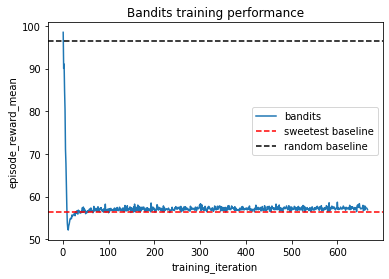

In [24]:
sns.lineplot(data=df, x="training_iteration", y="episode_reward_mean", label="bandits")
plt.axhline(sweetest_baseline, color="red", linestyle='--', label="sweetest baseline")
plt.axhline(random_baseline, color="k", linestyle='--', label="random baseline")

plt.legend()
plt.title('Bandits training performance')

## Compare the Bandit Training results to Baseline
- Bandit Mean Reward=~56 
- Kaleist (Argmin) Baseline Mean Reward = ~10.87+/-0.26
- Random Baseline Mean Reward = ~99.90+/-23.75
- Sweetest (Argmax) Baseline Mean Reward = ~56.56+/-1.37

<div class="alert alert-block alert-success">
    🤔  <b>Bandit mean reward is approx the same as the sweetest baseline!</b> 
</div>  

Try the code block below to compare what the bandit recommends with what is the sweetest item... you will see that the bandit always recommends the sweetest item!

In [25]:
# build the algorithm and load from checkpoint
with open("saved_runs/bandits/params.pkl", 'rb') as f:
    params = pickle.load(f)

In [26]:
bandit_algo = DQN(params)
bandit_algo

2022-09-16 10:39:52,332	WARNING deprecation.py:47 -- DeprecationWarning: `ray.rllib.algorithms.dqn.dqn.DEFAULT_CONFIG` has been deprecated. Use `ray.rllib.algorithms.dqn.dqn.DQNConfig(...)` instead. This will raise an error in the future!
2022-09-16 10:39:52,334	WARNING algorithm.py:2325 -- `evaluation_parallel_to_training` can only be done if `evaluation_num_workers` > 0! Setting `evaluation_parallel_to_training` to False.
2022-09-16 10:39:52,335	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!
2022-09-16 10:39:52,336	INFO simple_q.py:303 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting `simple_optimizer=True` if this doesn't work for you.
2022-09-16 10:39:52,338	INFO algorithm.py:357 -- Current log_level is ERROR. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v

DQN

In [27]:
# Load the checkpoint from the result folder of your running script
checkpoint = "saved_runs/bandits/checkpoint_000666"
bandit_algo.restore(checkpoint)

2022-09-16 10:39:56,403	INFO trainable.py:691 -- Restored on 127.0.0.1 from checkpoint: saved_runs/bandits/checkpoint_000666
2022-09-16 10:39:56,404	INFO trainable.py:700 -- Current state after restoring: {'_iteration': 666, '_timesteps_total': None, '_time_total': 53552.765288591385, '_episodes_total': 66600}


In [28]:
env = ModifiedLongTermSatisfactionRecSimEnv()
obs = env.reset()

# Run a single episode.
done = False
while not done:
    # use `compute_single_action` method of our Trainer.
    # This is one way to perform inference on a learned policy.
    bandit_action = bandit_algo.compute_single_action(obs) # TODO: Code here
    argmax_action = int(max(obs['doc'], key=lambda x: obs['doc'][x]))

    feature_value_of_bandit = obs["doc"][str(bandit_action)]
    feature_value_of_greedy = obs["doc"][str(argmax_action)]


    # Print out the picked document's feature value and compare that to the highest possible feature value.
    print("-"*50)
    print("observation_features: ", np.concatenate(list(obs["doc"].values())))
    print(f"bandit's feature value={feature_value_of_bandit}; argmax feature={feature_value_of_greedy};")

    # Apply the computed action in the environment and continue.
    obs, r, done, _ = env.step(bandit_action)

--------------------------------------------------
observation_features:  [0.99572366 0.15983172 0.8922959  0.15610583 0.8236549  0.12798421
 0.8286707  0.18893379 0.90436965 0.08293239 0.8529111  0.15484674
 0.89123005 0.11368679 0.80375797 0.1235271  0.92241913 0.1233868
 0.9887496  0.13636406]
bandit's feature value=[0.99572366]; argmax feature=[0.99572366];
--------------------------------------------------
observation_features:  [0.8719016  0.08740639 0.93952626 0.01204509 0.93335336 0.13412757
 0.84207654 0.02578526 0.8630857  0.07274216 0.9140394  0.0877203
 0.99767476 0.02040896 0.84177536 0.0322619  0.9306217  0.05065832
 0.89326215 0.04888512]
bandit's feature value=[0.99767476]; argmax feature=[0.99767476];
--------------------------------------------------
observation_features:  [0.8317939  0.02207503 0.9312659  0.02763659 0.8393165  0.07374503
 0.96419865 0.01942025 0.96758896 0.01921968 0.9952919  0.09373024
 0.9953522  0.1209691  0.94785273 0.00783756 0.85656136 0.024039

In this dummy Recsim environment, we did not have any user features.  This makes the contextual bandit without any user context, i.e. without any state.  A stateless bandit cannot remember things between timesteps, so it will sort of converge to the most greedy policy that recommends chocolotes.

# Solving the problem with RL <a class="anchor" id="dqn"></a>

So far the bandit solution has just converged to the perforamnce of greedy argmax policy. **How can we improve over the random policy baseline** Now let's run the DQN algorithm with $\gamma = 0.99$. We run this script for 1M environment timesteps till convergence. It will take ~ 1hour to run this training job.

**Exercise (1 min)** How would you modify the previous config object (`bandit_config`) to train an RL agent to optimize long-term engagement (hint: use `.training()` API)?


In [29]:
# TODO: Code here
dqn_config = bandit_config.training(gamma=0.99)

tuner = tune.Tuner(
    DQN,
    param_space=dqn_config.to_dict(),
    run_config=air.RunConfig(
        local_dir='./results_notebook/online_rl/dqn',
        stop={"training_iteration": 1},  # this is enough for it to converge
    )
)
dqn_results = tuner.fit()

(pid=65130) /opt/homebrew/Caskroom/miniforge/base/envs/ray/lib/python3.8/site-packages/tensorflow/core/framework/tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
(pid=65130)   DESCRIPTOR = _descriptor.FileDescriptor(
(pid=65130) /opt/homebrew/Caskroom/miniforge/base/envs/ray/lib/python3.8/site-packages/tensorflow/core/framework/tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
(pid=65130)   _descriptor.FieldDescriptor(
(pid=65130) /opt/homebrew/Caskroom/miniforge/base/envs/ray/lib/python3.8/site-packages/tensorflow/core/framework/tensor_shape_pb2.py:29: DeprecationWarning: Call to deprecated create function Descriptor(). N

Trial name,agent_timesteps_total,counters,custom_metrics,date,done,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,episodes_total,experiment_id,hostname,info,iterations_since_restore,node_ip,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_trained,num_env_steps_trained_this_iter,num_faulty_episodes,num_healthy_workers,num_recreated_workers,num_steps_trained_this_iter,perf,pid,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,sampler_results,time_since_restore,time_this_iter_s,time_total_s,timers,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
DQN_modified-lts_944b2_00000,1000,"{'num_env_steps_sampled': 1000, 'num_env_steps_trained': 0, 'num_agent_steps_sampled': 1000, 'num_agent_steps_trained': 0}",{},2022-09-16_10-40-01,True,10,{},157.216,103.308,47.8911,100,100,575e972948bc44258ef16db193644c7b,Kouroshs-MacBook-Pro-13,"{'learner': {}, 'num_env_steps_sampled': 1000, 'num_env_steps_trained': 0, 'num_agent_steps_sampled': 1000, 'num_agent_steps_trained': 0}",1,127.0.0.1,1000,0,1000,1000,0,0,0,0,0,0,"{'cpu_util_percent': 26.5, 'ram_util_percent': 73.6}",65130,{},{},{},"{'mean_raw_obs_processing_ms': 0.7084697395652445, 'mean_inference_ms': 0.4940752263788459, 'mean_action_processing_ms': 0.020375142207036127, 'mean_env_wait_ms': 0.14750512091668097, 'mean_env_render_ms': 0.0}","{'episode_reward_max': 157.21604582369264, 'episode_reward_min': 47.89108132846751, 'episode_reward_mean': 103.30797269596522, 'episode_len_mean': 10.0, 'episode_media': {}, 'episodes_this_iter': 100, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [99.11045227234092, 81.77585776511727, 84.3415585617816, 109.06625628022462, 92.27350015040574, 72.64437346757511, 77.8549420881666, 83.0277873113271, 68.8528079312469, 64.83050025464037, 115.26974289398636, 109.47309693862519, 122.67982077096659, 100.03901569098119, 123.79127382854766, 112.89459346881773, 113.91232649056761, 109.49399783310301, 82.6370642518649, 70.53887372734265, 128.76632875084366, 84.2724463180759, 97.40616233547158, 116.40979359538777, 108.53579794798723, 95.8697716843338, 107.09144874230302, 127.98009906254937, 55.95314352687059, 143.8243141647193, 96.3801047565567, 78.1593915977648, 124.74220220835045, 76.71202556732163, 107.28434051617066, 112.95509425912155, 138.5291454797608, 51.0774331012877, 139.01770834399076, 111.69031251590302, 104.46242520416102, 134.38715150209703, 134.13759197089024, 103.97461130736812, 57.40523824626669, 129.41434716669102, 93.4460044613155, 113.45520862089512, 84.50496024440214, 147.49992559776265, 145.34374025233924, 103.92147286965454, 100.5431287363312, 89.46208702996897, 112.58175045048844, 82.02357508394614, 99.41740929734472, 146.0200815752321, 95.72244404239994, 94.17610226926041, 92.80010296402101, 93.72649778184048, 59.444559753831534, 127.63634703382014, 105.80824346211328, 128.5721991453306, 103.94784170344461, 100.35902118802292, 105.9370926434695, 121.86792204002342, 95.19179674330466, 131.17955928783675, 128.13228139101753, 109.2749263270398, 139.1885025384312, 117.73200567619926, 157.21604582369264, 107.9455899456126, 97.34201457068505, 90.5654556571637, 47.89108132846751, 110.42512266712015, 68.72235148593494, 85.79221235085255, 143.84040128257922, 95.33244141133554, 149.56127661350243, 99.50299390562441, 116.70611809617999, 93.38000833330426, 136.6467513067201, 95.38190849593268, 117.89863456815856, 81.01556506219924, 84.57791319205757, 91.53396296355942, 84.72573482007071, 92.99761040408204, 69.06167945167931, 82.87133379904553], 'episode_lengths': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

2022-09-16 10:40:02,635	INFO tune.py:762 -- Total run time: 6.13 seconds (5.41 seconds for the tuning loop).



**(Take Home)** You can run the same script as before, with `gamma=0.99` passed in as a parameter. We should also run the script longer (1M steps) as it will take longer for DQN to converge. 
```bash
python tutorial_scripts/run_online_rl.py --seed 0 --gamma 0.99 --exp_name dqn --timesteps 1_000_000
```

**Exercise** Take a look at the results and compare them to bandits via tensorboard.

In [30]:
# take a look at the results
bandit_df = pd.read_csv("saved_runs/bandits/progress.csv")
dqn_df = pd.read_csv("saved_runs/dqn/progress.csv")

Text(0.5, 1.0, 'RL vs. Bandits training performance')

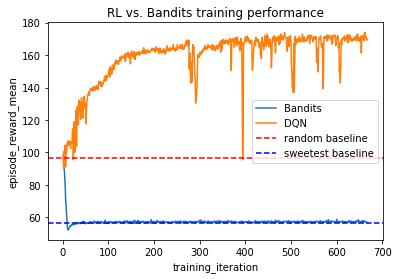

In [31]:
# plot the results and compare to baselines
sns.lineplot(data=bandit_df, x="training_iteration", y="episode_reward_mean", label="Bandits")
sns.lineplot(data=dqn_df, x="training_iteration", y="episode_reward_mean", label="DQN")
plt.axhline(random_baseline, color="red", linestyle='--', label="random baseline")
plt.axhline(sweetest_baseline, color="blue", linestyle='--', label="sweetest baseline")
plt.legend()
plt.title('RL vs. Bandits training performance')


- **Sweetest** straight line, is the mean reward achieved by the greedy policy, selecting always the item with most immediate reward value.
- **Bandit** short term reward hovers around the "sweetest baseline".
- **Random** straight line, items are randomly chosen to be recommended at each timestep. Since this baseline mixes the sweetest and kaliest options the engagement is kept higher than either of the greedy methods, obtaining larger rewards.
- **DQN (RL)**, such as DQN that optimize for long-term engagement significantly improves upon random baselines.

# Questions and Break (5 min) <a class="anchor" id="break"></a>

# Offline RL with RecSys <a class="anchor" id="offline-rl"></a>

<img src="images/offline_rl.png">


### If we don't have a live environment, how do we know, how well our trained policy will perform?

One of the challenges in offline RL is the evaluation of the trained policy. In online RL (when a simulator
is available), one can either use the data collected for training to compute episode total rewards. Remember
that observations, actions, rewards, and done flags are all part of this training data. Alternatively,
one could run a separate worker (with the same trained policy) and run it on a fresh evaluation-only environment.
In this latter case, we would also have the chance to switch off any exploratory behavior (e.g. stochasticity used
for better action entropy).

In offline RL, no such data from a live environment is available to us. There are two common ways of addressing this dilemma:

1) We deploy the learned policies into production, or maybe just a portion of our production system (similar to A/B testing), and see what happens.

2) We use a method called "off policy evaluation" (OPE) to compute an estimate on how the new policy would perform if we were to deploy it into a real environment. There are different OPE methods available in RLlib off-the-shelf.

3) The third option - which we will use here - is kind of cheating and only possible if you actually do have a simulator available (but you only want to use it for evaluation, not for training, because you want to see how cool offline RL is :) )

In this tutorial, we will use the third option to show the effectiveness of offline RL in improving over existing policies running in production. We will also see how much benefit we can get by improving our dataset quality, starting from a totally random policy all the way to 20% expert demonstrations adn 80% random. 

We can use the currently running policies in production to collect some "historical data" that we can use to train RL agents with. Offline RL can be used to improve upon the existing policies deployed in production. We have prepared some datasets in advance for the purpose of this tutorial. They were all generated using `<path to the script>`. In this script we can mix the percentage of the "expert" data vs. random data to investigate the effect of dataset quality on the final performance of our models.   

Let's look at an exemplar dataset we have prepared before:



In [32]:
prefix = "s3://air-example-data/rllib/acm_recsys22_tutorial_data/"
train_data_path = prefix + "sampled_data_train_random_transitions_small"

dset = data.read_json(train_data_path)
df = dset.to_pandas()
print('Colimns: ', df.columns)
print('Number of rows: ', len(df))
print('Value of the first row')
print('-'*20)
print(df.iloc[0])
print('Value of the second row:')
print('-'*20)
print(df.iloc[1])


2022-09-16 10:40:08,459	WARNING read_api.py:291 -- ⚠️  The number of blocks in this dataset (1) limits its parallelism to 1 concurrent tasks. This is much less than the number of available CPU slots in the cluster. Use `.repartition(n)` to increase the number of dataset blocks.


Colimns:  Index(['type', 'obs', 'new_obs', 'actions', 'rewards', 'dones', 'eps_id', 't',
       'action_prob'],
      dtype='object')
Number of rows:  100
Value of the first row
--------------------
type                                                 SampleBatch
obs            BCJNGGhAMAQAAAAAAACKIgIAAGGABZUlBAABAPEcjBVudW...
new_obs        BCJNGGhALQQAAAAAAABmHgIAAGGABZUiBAABAPEcjBVudW...
actions                                                      [0]
rewards                                      [22.45008736559994]
dones                                                    [False]
eps_id                                                       [0]
t                                                            [0]
action_prob                                               [0.05]
Name: 0, dtype: object
Value of the second row:
--------------------
type                                                 SampleBatch
obs            BCJNGGhALQQAAAAAAABmHgIAAGGABZUiBAABAPEcjBVudW...
new_obs        BC

From the dataset schema, we can see that RLlib always expects a `type` column that is `SampleBatch`. It will have the normal transition entities per each row (i.e. observation, next_observation, action, reward, done values). It will also contain an episode_id, a timestep indicator, and an action_prob that show the probablity of the action that we chosen at the time of data collection. For random policy the action prob will always be 1/20 (0.05). 

Now that we have an understaning of the dataset example format, we can use RLlib to train an offline RL algorithm. RLlib provides several out of the box offline RL algorithms that you can use. Beside those offline-RL-specific algorithms, we can also use any off-policy algorithm (e.g. DQN) to do offline-RL. The only difference between online and offline version is that instead of using an enviornement sampler, we use a dataset sampler to get the data from. In the next section, we will use DQN, with the difference that we pass a dataset path to the input config.

Here is the summary of the differences:

- Change the input config from a sample to offline dataset is configured by `.offline_data()` API:

```python
    .offline_data(
        input_='dataset',
        input_config={
            'format': 'json',
            'paths': train_data_path
        }
    )
```

- The environment is not passed to the enviornement anymore. Instead we need to pass in the expected action and observation space to construct the policies. We can create them manually based on our knowledge of our system. In this case we actually cheat and use the environment attributes to get the correct action and observatin spaces.

```python 
    .environment(
        action_space=action_space,
        observation_space=observation_space,
    )
```

- evaluation config: Since during the evaluation we still need to use the enviroenement simulations, we need to specify it explicitly here. RLlib by default will use the training settings during evaluation and to avoid that default behavior we need to explicitly specify the simulation environment configs. 

```python
    .evaluation(
        evaluation_interval=1,
        evaluation_config={
            "input": "sampler",
            "explore": False,
            "env": "modified-lts"
        },
    )
```

Running the script below takes about 1 hour. 

In [33]:
env = ModifiedLongTermSatisfactionRecSimEnv()
action_space = env.action_space
observation_space = env.observation_space

dqn_config_offline = (
    DQNConfig()
    .offline_data(
        input_='dataset',
        input_config={
            'format': 'json',
            'paths': train_data_path,
        }
    )
    .environment(
        action_space=action_space,
        observation_space=observation_space,
    )
    .evaluation(
        evaluation_interval=1,
        evaluation_config={
            "input": "sampler",
            "explore": False,
            "env": "modified-lts",
        },
    )
    .training(gamma=0.99)
)

**(Take Home)** To run the long-running learning script run:

```bash
python tutorial_scripts/run_offline_rl.py --dataset_suffix sampled_data_train_random_transitions
```

In [34]:
tuner = tune.Tuner(
    DQN,
    param_space=dqn_config_offline.to_dict(),
    run_config=air.RunConfig(
        local_dir="./results_notebook/offline_rl/",
        stop={"training_iteration": 1},
    )
)
dqn_offline_results = tuner.fit()

(pid=65165) /opt/homebrew/Caskroom/miniforge/base/envs/ray/lib/python3.8/site-packages/tensorflow/core/framework/tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
(pid=65165)   DESCRIPTOR = _descriptor.FileDescriptor(
(pid=65165) /opt/homebrew/Caskroom/miniforge/base/envs/ray/lib/python3.8/site-packages/tensorflow/core/framework/tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
(pid=65165)   _descriptor.FieldDescriptor(
(pid=65165) /opt/homebrew/Caskroom/miniforge/base/envs/ray/lib/python3.8/site-packages/tensorflow/core/framework/tensor_shape_pb2.py:29: DeprecationWarning: Call to deprecated create function Descriptor(). N

(DQN pid=65165) DatasetReader 0 has 100, samples.


(DQN pid=65165) 2022-09-16 10:40:18,637	WARNING util.py:66 -- Install gputil for GPU system monitoring.
(DQN pid=65165) 2022-09-16 10:40:19,534	WARNING deprecation.py:47 -- DeprecationWarning: `ReplayBuffer.add_batch()` has been deprecated. Use `ReplayBuffer.add()` instead. This will raise an error in the future!
(DQN pid=65165) 2022-09-16 10:40:26,360	WARNING deprecation.py:47 -- DeprecationWarning: `concat_samples` has been deprecated. Use `concat_samples() from rllib.policy.sample_batch` instead. This will raise an error in the future!


Trial name,agent_timesteps_total,counters,custom_metrics,date,done,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,episodes_total,evaluation,experiment_id,hostname,info,iterations_since_restore,node_ip,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_trained,num_env_steps_trained_this_iter,num_faulty_episodes,num_healthy_workers,num_recreated_workers,num_steps_trained_this_iter,perf,pid,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,sampler_results,time_since_restore,time_this_iter_s,time_total_s,timers,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
DQN_None_9c219_00000,1024,"{'num_env_steps_sampled': 1024, 'num_env_steps_trained': 32, 'num_agent_steps_sampled': 1024, 'num_agent_steps_trained': 32, 'last_target_update_ts': 1024, 'num_target_updates': 1}",{},2022-09-16_10-40-26,True,nan,{},nan,nan,nan,0,0,"{'episode_reward_max': 123.72624007752286, 'episode_reward_min': 91.77170300312751, 'episode_reward_mean': 106.54626415417022, 'episode_len_mean': 10.0, 'episode_media': {}, 'episodes_this_iter': 10, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [99.20319381064273, 114.58431149830305, 105.77463002614269, 104.2546325159897, 123.72624007752286, 113.724310883201, 103.14326853220415, 91.77170300312751, 111.5091498457418, 97.77120134882674], 'episode_lengths': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]}, 'sampler_perf': {'mean_raw_obs_processing_ms': 0.7005965355599281, 'mean_inference_ms': 0.6371913569988592, 'mean_action_processing_ms': 0.027104179457862775, 'mean_env_wait_ms': 0.16684343319128053, 'mean_env_render_ms': 0.0}, 'num_faulty_episodes': 0, 'num_agent_steps_sampled_this_iter': 100, 'num_env_steps_sampled_this_iter': 100, 'timesteps_this_iter': 100, 'num_healthy_workers': 0, 'num_recreated_workers': 0}",82d94e19a2074eafa06e94998252d4b4,Kouroshs-MacBook-Pro-13,"{'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'mean_q': -0.015671823, 'min_q': -0.7128436, 'max_q': 0.8172291, 'mean_td_error': -14.410912, 'model': {}}, 'td_error': array([ -2.4671602, -47.228054 , -2.0665014, -26.59089 , -2.5970614, -1.2217431, -1.9884274, -1.1730783, -19.121237 , -40.622494 , -1.6262618, -1.9609916, -2.4885855, -1.5764354, -2.3379889, -1.993646 , -1.9785019, -8.877396 , -80.83335 , -1.894833 , -55.23862 , -38.65941 , -55.23862 , -46.258427 , -1.2217431, -2.5359395, -1.9609916, -1.6852688, -2.1833062, -2.4671602, -1.5862249, -1.4688587], dtype=float32), 'custom_metrics': {}, 'num_agent_steps_trained': 32.0}}, 'num_env_steps_sampled': 1024, 'num_env_steps_trained': 32, 'num_agent_steps_sampled': 1024, 'num_agent_steps_trained': 32, 'last_target_update_ts': 1024, 'num_target_updates': 1}",1,127.0.0.1,1024,32,1024,1024,32,32,0,0,0,32,"{'cpu_util_percent': 18.650000000000002, 'ram_util_percent': 73.525}",65165,{},{},{},{},"{'episode_reward_max': nan, 'episode_reward_min': nan, 'episode_reward_mean': nan, 'episode_len_mean': nan, 'episode_media': {}, 'episodes_this_iter': 0, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [], 'episode_lengths': []}, 'sampler_perf': {}, 'num_faulty_episodes': 0}",8.06543,8.06543,8.06543,"{'training_iteration_time_ms': 185.676, 'load_time_ms': 0.085, 'load_throughput': 375960.022, 'learn_time_ms': 118.783, 'learn_throughput': 269.399, 'synch_weights_time_ms': 0.025}",1663350026,0,1024,1,9c219_00000,4.80785


2022-09-16 10:40:27,208	INFO tune.py:762 -- Total run time: 17.55 seconds (17.12 seconds for the tuning loop).


Let's now look at the offline training results. From the plot below we can see that by running offline RL on randomly collected transitions we can improve over the random policy. This is extremely useful in practical scenarios where our goal is to improve over existing production policies.

In [35]:
dqn_offline_results

In [36]:
print('Mean Episode reward:')
dqn_offline_results[0].metrics['evaluation']['episode_reward_mean']

Mean Episode reward:


106.54626415417022

In [37]:
# plot the results and compare to baselines
offline_dqn_df = pd.read_csv("saved_runs/dqn_offline/random_data/progress.csv")

Text(0.5, 1.0, 'Offline RL vs. Baselines training performance')

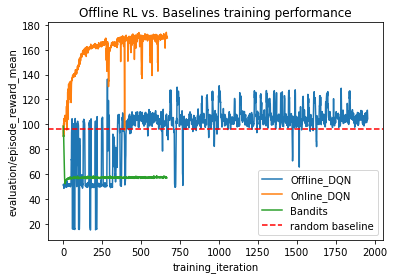

In [38]:

sns.lineplot(data=offline_dqn_df, x="training_iteration", y="evaluation/episode_reward_mean", label="Offline_DQN")
sns.lineplot(data=dqn_df, x="training_iteration", y="episode_reward_mean", label="Online_DQN")
sns.lineplot(data=bandit_df, x="training_iteration", y="episode_reward_mean", label="Bandits")
plt.axhline(random_baseline, color="red", linestyle='--', label="random baseline")
plt.legend()
plt.title('Offline RL vs. Baselines training performance')

## Conclusion

- Bandits converges to a short-sighted solution
    -  Optimizes imediate reward. 
- DQN takes long-term reward into account
    -  Achieves a policy better than random.
- Offline RL is a viable option that works when we don't have simulators for training
    -  Since it doesn't explore freely it won't perform as good as an online RL method. 
    -  Its performance is bounded to the quality of the dataset.


### References

1. 📖 [Ray summit tutorials on RLlib](https://github.com/anyscale/ray-summit-2022-training/tree/main/ray-rllib)
2. 👩‍ [RLlib Documentation](https://docs.ray.io/en/latest/rllib/index.html)

## Thank you!

<a href="https://docs.google.com/forms/d/1pxsMIPMxTTd2HH6710UOApx_smPDPPO0fpVWYKzvOgI/edit">Survey</a> - Please let us know how useful you have found this tutorial.

**We would love to connect with you!**

**Twitter** - @anyscalecompute | @raydistributed <br>
<b><a href="https://github.com/ray-project/ray">Github</a></b> - 😜 give us a star!<br>
<b><a href="https://www.ray.io/community">Slack</a></b> - [+invitation link](https://docs.google.com/forms/d/e/1FAIpQLSfAcoiLCHOguOm8e7Jnn-JJdZaCxPGjgVCvFijHB5PLaQLeig/viewform)<br>
<b><a href="https://discuss.ray.io/">Discuss</a></b> - searchable questions <br>